In [1]:
import pymc3 as pm

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

### Start SES

In [ ]:
# [] simulate data
# [] model with only a level component
# [] can we get it working with and without a for loop?
    # can try:
        # defining operations outside of the model
        # using theano.scan
        # slicing trick?
    # look at n variables with these different methods. Maybe should be reducing the #

<AxesSubplot:>

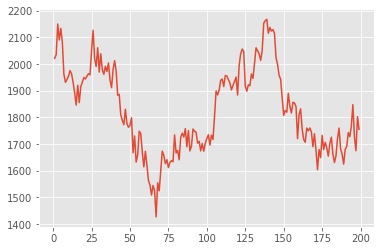

In [313]:
### Specifying SES as State Space Model

initial_level, smoothing_level = 2000, 0.8

ys = [None for i in range(200)]
ls = [None for i in range(200)]
ls[0] = initial_level

for i in range(1, 200):
    
    noise = np.random.normal(0, 50)
    ys[i] = ls[i-1] + noise
    ls[i] = ls[i-1] + smoothing_level * noise

d = pd.DataFrame({'y': ys, 'level': ls})

d['y_lag-1'] = d.y.shift(-1)

d.y.plot()

In [ ]:
    # can try to get rid of the loops here (1 below and above)
    # can we do matrix mul/linear alg instead?
        # ie maybe it doesn't matter that we iteratively build up? since it is compiled all at once
    # define outside?
    # use theano.scan?
    # could look at pyro
    # could look at just using torch or scipy and just coding up the model by hand like statsmodels is doing
    
    # look at number of vars
    # maybe the pm.Deterministic is unecessarily adding to the theano nodes / tracked var's

In [94]:
import theano.tensor as tt

In [125]:
d_short = d.loc[:55, :]

In [126]:
with pm.Model() as ses_model:
    initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000)
    smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
    
    # move this out? or use scan? does this create unnecessary var's?
    levels = [1.0 for i in range(len(d_short))]
    levels[0] = initial_level
    
    # move this out? or use scan? does this create unnecessary var's?
    for i in range(1, len(d_short)):
#         levels[i] = pm.Deterministic(f'level_{i}',smoothing_level*(d_short.loc[i]['y']) \
#                                      + (1 - smoothing_level)*(levels[i-1]))
        levels[i] = smoothing_level*(d_short.loc[i]['y']) + (1 - smoothing_level)*(levels[i-1])

    # Y(t+1) = L(t)
#     y_hats = np.array(levels[:-1])
#     y_hats = tt.as_tensor_variable(levels[:-1])
    y_hats = pm.math.stack([levels[:-1]])
#     y_hats = levels[:-1]
    
#     levels_and_slopes = pm.math.stack([levels[:-1], slopes[:-1]])
#     levels_plus_slopes = levels_and_slopes.sum(axis=0)
#     levels_slopes_seasons = pm.math.stack([levels_plus_slopes, seasons[:-1]])
#     y_hats = levels_slopes_seasons.prod(axis=0)
    
    sigma = pm.Uniform('sigma', lower=0, upper=400)
    y_like = pm.Normal('y_like', mu=y_hats, sigma=sigma, observed=d_short.iloc[:-1, :]['y_lag-1'])

In [167]:
import theano

In [174]:
## using component form here (this just to check theano.scan implementation)

ys = [0,1,2,3]
smoothing_l = 0.8
initial_l = 1
ls = [initial_l, 1.0, 1.0, 1.0]

for i in range(1, len(ys)):
    ls[i] = smoothing_l*ys[i] + (1 - smoothing_l)*ls[i-1]

In [175]:
ls

[1, 1.0, 1.8, 2.7600000000000002]

In [181]:
# repro ^ with theano
# sounds like the inputs should be theano var's. Maybe they can take lists or np.arrays and convert?

outputs, updates = theano.scan(fn = lambda y, prior_level: smoothing_l * y + (1 - smoothing_l) * prior_level,
           sequences = [
               np.array(ys[1:])
           ], # first arg should be ys[t]
           outputs_info = [
               dict(initial = pm.math.floatX(ls[0]), taps=None)
           ], # taps = None is equivalent to taps=[-1]
#            non_sequences = 
           )

WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 


In [183]:
outputs.get_test_value()

array([1.  , 1.8 , 2.76])

In [495]:
with pm.Model() as ses_model:
    sigma = pm.Uniform(f'sigma', lower=0, upper=400, shape=len(ys)-2)

In [496]:
sigma[0]

Subtensor{int64}.0

In [497]:
sigma

sigma ~ Uniform

In [503]:
sigma.get_test_value().shape[0]

198

In [504]:
# trying to express model in state-space form. but would still need to use theano.scan here

# with pm.Model() as ses_model:
#     initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000)
#     smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
    
#     levels = [1.0 for i in range(len(d))]
#     levels[0] = initial_level
    
#     ys = d['y']
#     sigma = pm.Uniform(f'sigma', lower=0, upper=400)
#     for i in range(1, len(ys)-1):
# #         sigma = pm.Uniform(f'sigma_{i}', lower=0, upper=400)
#         y_like = pm.Normal(f'y_{i}', mu=levels[i-1], sigma=sigma, observed=d.loc[i]['y_lag-1'])
#         level_i = pm.Normal(f'l_{i}', mu=levels[i-1], sigma=smoothing_level*sigma)
#         levels[i] = level_i

# with ses_model:
# #     ses_trace = pm.sample(draws=2000, tune=2000, target_accept=0.95)
# #     ses_trace = pm.sample(draws=16000)
#     ses_trace = pm.sample()

In [296]:
with pm.Model() as ses_model:
#     initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000, shape=(1,1))
    initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000)
    smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
    
    # move this out? or use scan? does this create unnecessary var's?
#     levels = [1.0 for i in range(len(d))]
#     levels[0] = initial_level
    
    # move this out? or use scan? does this create unnecessary var's?
#     for i in range(1, len(d)):
# #         levels[i] = pm.Deterministic(f'level_{i}',smoothing_level*(d.loc[i]['y']) \
# #                                      + (1 - smoothing_level)*(levels[i-1]))
#         levels[i] = smoothing_level*(d.loc[i]['y']) + (1 - smoothing_level)*(levels[i-1])

    ys = d['y']
    
    levels, updates = theano.scan(fn = lambda y, prior_level: smoothing_level * y + (1 - smoothing_level) * prior_level,
           sequences = [
               np.array(ys[1:])
           ], # first arg should be ys[t]
           outputs_info = [
#                dict(initial = pm.math.floatX(ls[0]), taps=None)
               dict(initial = initial_level, taps=None)
           ], # taps = None is equivalent to taps=[-1]
#            non_sequences = 
           )

    # Y(t+1) = L(t)
#     y_hats = np.array(levels[:-1])
#     y_hats = tt.as_tensor_variable(levels[:-1])
    y_hats = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
#     y_hats = levels[:-1]
    
#     levels_and_slopes = pm.math.stack([levels[:-1], slopes[:-1]])
#     levels_plus_slopes = levels_and_slopes.sum(axis=0)
#     levels_slopes_seasons = pm.math.stack([levels_plus_slopes, seasons[:-1]])
#     y_hats = levels_slopes_seasons.prod(axis=0)
    
    sigma = pm.Uniform('sigma', lower=0, upper=400)
    y_like = pm.Normal('y_like', mu=y_hats, sigma=sigma, observed=d.iloc[:-1, :]['y_lag-1'])

WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 


In [297]:
with ses_model:
#     ses_trace = pm.sample(draws=2000, tune=2000, target_accept=0.95)
#     ses_trace = pm.sample(draws=16000)
    ses_trace = pm.sample()

<ipython-input-297-61fa207d68dc>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  ses_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, smoothing_level, initial_level]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


<ipython-input-298-72d66f4cf359>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(ses_trace)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'initial_level'}>,
        <AxesSubplot:title={'center':'initial_level'}>],
       [<AxesSubplot:title={'center':'smoothing_level'}>,
        <AxesSubplot:title={'center':'smoothing_level'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

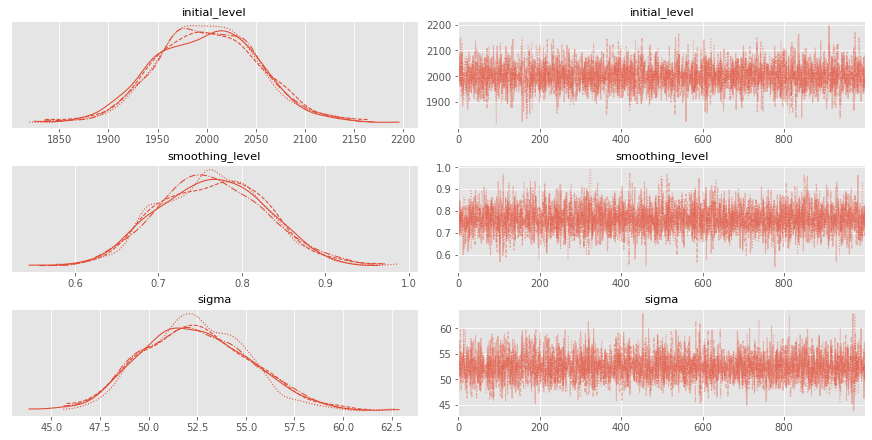

In [298]:
pm.traceplot(ses_trace)

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

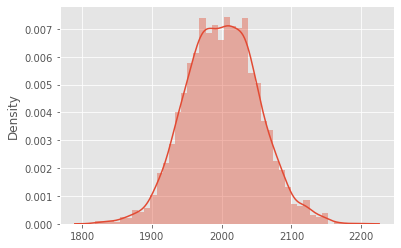

In [299]:
sns.distplot(ses_trace['initial_level'])

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

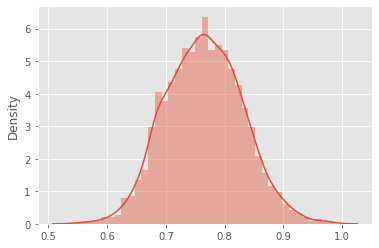

In [300]:
sns.distplot(ses_trace['smoothing_level'])

In [302]:
mean_initial_level = ses_trace['initial_level'].mean()
mean_initial_level

2000.7074606817241

In [303]:
mean_smoothing_level = ses_trace['smoothing_level'].mean()
mean_smoothing_level

0.7649429179525346

In [305]:
mean_sigma = ses_trace['sigma'].mean()
mean_sigma

52.45097526757168

In [306]:
d.loc[0, 'level_hat'] = mean_initial_level

In [307]:
d.head(6)

,y,level,y_lag-1,level_hat
0,NaN,2000.000000,1998.820056,2000.707461
1,1998.820056,1999.056045,2012.205226,1999.194818
2,2012.205226,2009.575390,2002.970845,2009.603144
3,2002.970845,2004.291754,1978.642590,2004.297305
4,1978.642590,1983.772423,1969.928962,1983.773533
5,1969.928962,1972.697654,1978.794232,1972.697876


In [308]:
for idx, row in d.iloc[1:,:].iterrows():
#     print('idx', idx)
    
    level_minus_1 = d.loc[idx-1]['level_hat']
    y = row['y']
#     print('level_minus_1', level_minus_1)
#     print('y', y)
    
    d.loc[idx, 'level_hat'] = mean_smoothing_level * y + (1 - mean_smoothing_level) * level_minus_1

<AxesSubplot:>

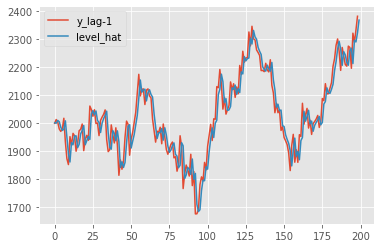

In [309]:
d[['y_lag-1', 'level_hat']].plot()

In [ ]:
# seems like pm.math.stack() gets the levels list to be the right data type
# still not clear though why the other ways don't work (ie just using a np.array, seemed like that is something that should be convertible to a theano object, per different discussions online)

### End SES

### Start With Trend Component

<AxesSubplot:>

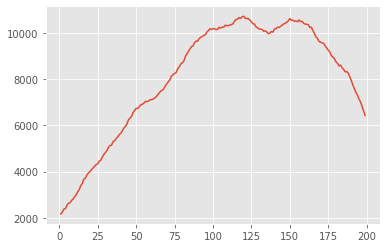

In [356]:
### Specifying DES as State Space Model
### ETS(A,A,N)

initial_level, smoothing_level = 2000, 0.8
initial_trend, smoothing_trend = 100, 0.3

ys = [None for i in range(200)]
ls = [None for i in range(200)]
bs = [None for i in range(200)]
ls[0] = initial_level
bs[0] = initial_trend
noises = []

for i in range(1, 200):
    
    noise = np.random.normal(0, 50)
    noises.append(noise)
    ys[i] = ls[i-1] + bs[i-1] + noise
    ls[i] = ls[i-1] + bs[i-1] + smoothing_level * noise
    bs[i] = bs[i-1] + smoothing_trend * noise

d2 = pd.DataFrame({'y': ys, 'level': ls, 'trend': bs})

d2['y_lag-1'] = d2.y.shift(-1)

d2.y.plot()

<AxesSubplot:>

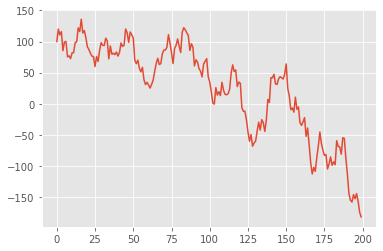

In [357]:
d2.trend.plot()

<AxesSubplot:>

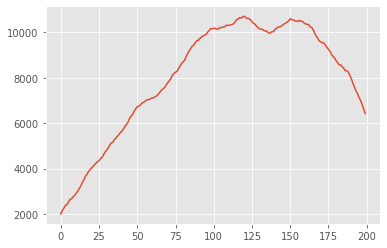

In [358]:
d2.level.plot()

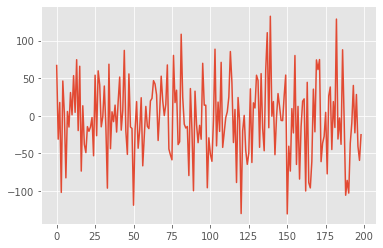

In [359]:
plt.plot(noises)

In [360]:
pd.Series(noises).describe()

count    199.000000
mean      -4.719100
std       50.546048
min     -130.705694
25%      -37.309157
50%       -6.505712
75%       26.546124
max      132.473110
dtype: float64

In [363]:
## using component form here (this just to check theano.scan implementation)

ys = [0,1,2,3]

smoothing_l = 0.8
initial_l = 1
ls = [initial_l, None, None, None]

smoothing_b = 0.6
initial_b = 0.2
bs = [initial_b, None, None, None]

for i in range(1, len(ys)):
    ls[i] = smoothing_l*ys[i] + (1 - smoothing_l)*(ls[i-1] + bs[i-1])
    bs[i] = smoothing_b*(ls[i] - ls[i-1]) + (1 - smoothing_b)*bs[i-1]

In [364]:
ls

[1, 1.04, 1.8288, 2.868736]

In [365]:
bs

[0.2, 0.10400000000000004, 0.5148799999999999, 0.8299136]

In [366]:
# repro ^ with theano
# sounds like the inputs should be theano var's. Maybe they can take lists or np.arrays and convert?

def my_func(y, prior_level, prior_trend):
    next_level = smoothing_l * y + (1 - smoothing_l)*(prior_level + prior_trend)
    next_trend = smoothing_b * (next_level - prior_level) + (1 - smoothing_b)*prior_trend
    
    return next_level, next_trend

outputs, updates = theano.scan(my_func,
           sequences = [
               np.array(ys[1:])
           ], # first arg should be ys[t]
           outputs_info = [
               dict(initial = pm.math.floatX(ls[0]), taps=None),
               dict(initial = pm.math.floatX(bs[0]), taps=None)
           ], # taps = None is equivalent to taps=[-1]
#            non_sequences = 
           )

WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 
WARNING (theano.link.c.cmodule): Removing key file /Users/sorenzeliger/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.9.0-64/tmp066qjlz_/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/sorenzeliger/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.9.0-64/tmp4bheqbsc/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/sorenzeliger/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.9.0-64/tmp55ubetbq/key.pkl because the corresponding module is gone from the file system.
WARNING (theano.link.c.cmodule): Removing key file /Users/sorenzeliger/.theano/compiledir_macOS-10.15.7-x86_64-i386-64bit-i386-3.

In [370]:
outputs[0].get_test_value()

array([1.04    , 1.8288  , 2.868736])

In [371]:
outputs[1].get_test_value()

array([0.104    , 0.51488  , 0.8299136])

In [372]:
with pm.Model() as ses_model:
#     initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000, shape=(1,1))
    initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000)
    smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
    initial_trend = pm.Uniform(f'initial_trend', lower=-5000, upper=5000)
    smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
    
    # move this out? or use scan? does this create unnecessary var's?
#     levels = [1.0 for i in range(len(d))]
#     levels[0] = initial_level
    
    # move this out? or use scan? does this create unnecessary var's?
#     for i in range(1, len(d)):
# #         levels[i] = pm.Deterministic(f'level_{i}',smoothing_level*(d.loc[i]['y']) \
# #                                      + (1 - smoothing_level)*(levels[i-1]))
#         levels[i] = smoothing_level*(d.loc[i]['y']) + (1 - smoothing_level)*(levels[i-1])

    ys = d2['y']
    
#     levels, updates = theano.scan(fn = lambda y, prior_level: smoothing_level * y + (1 - smoothing_level) * prior_level,
#            sequences = [
#                np.array(ys[1:])
#            ], # first arg should be ys[t]
#            outputs_info = [
# #                dict(initial = pm.math.floatX(ls[0]), taps=None)
#                dict(initial = initial_level, taps=None)
#            ], # taps = None is equivalent to taps=[-1]
# #            non_sequences = 
#            )
    
    def level_and_trend_fn(y, prior_level, prior_trend):
        next_level = smoothing_level * y + (1 - smoothing_level)*(prior_level + prior_trend)
        next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend

        return next_level, next_trend
    
    outputs, updates = theano.scan(level_and_trend_fn,
           sequences = [
               np.array(ys[1:])
           ], # first arg should be ys[t]
           outputs_info = [
               dict(initial = initial_level, taps=None),
               dict(initial = initial_trend, taps=None)
           ], # taps = None is equivalent to taps=[-1]
#            non_sequences = 
           )
    
    levels = outputs[0]
    trends = outputs[1]

    levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
    trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
    
    levels_and_trends = pm.math.stack([levels_f, trends_f])
    y_hats = levels_and_trends.sum(axis=0)
    
#     levels_and_slopes = pm.math.stack([levels[:-1], slopes[:-1]])
#     levels_plus_slopes = levels_and_slopes.sum(axis=0)
#     levels_slopes_seasons = pm.math.stack([levels_plus_slopes, seasons[:-1]])
#     y_hats = levels_slopes_seasons.prod(axis=0)
    
    sigma = pm.Uniform('sigma', lower=0, upper=400)
    y_like = pm.Normal('y_like', mu=y_hats, sigma=sigma, observed=d2.iloc[:-1, :]['y_lag-1'])

WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


In [373]:
with ses_model:
#     ses_trace = pm.sample(draws=2000, tune=2000, target_accept=0.95)
#     ses_trace = pm.sample(draws=16000)
    ses_trace = pm.sample()

<ipython-input-373-61fa207d68dc>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  ses_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, smoothing_trend, initial_trend, smoothing_level, initial_level]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


<ipython-input-374-72d66f4cf359>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(ses_trace)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'initial_level'}>,
        <AxesSubplot:title={'center':'initial_level'}>],
       [<AxesSubplot:title={'center':'smoothing_level'}>,
        <AxesSubplot:title={'center':'smoothing_level'}>],
       [<AxesSubplot:title={'center':'initial_trend'}>,
        <AxesSubplot:title={'center':'initial_trend'}>],
       [<AxesSubplot:title={'center':'smoothing_trend'}>,
        <AxesSubplot:title={'center':'smoothing_trend'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

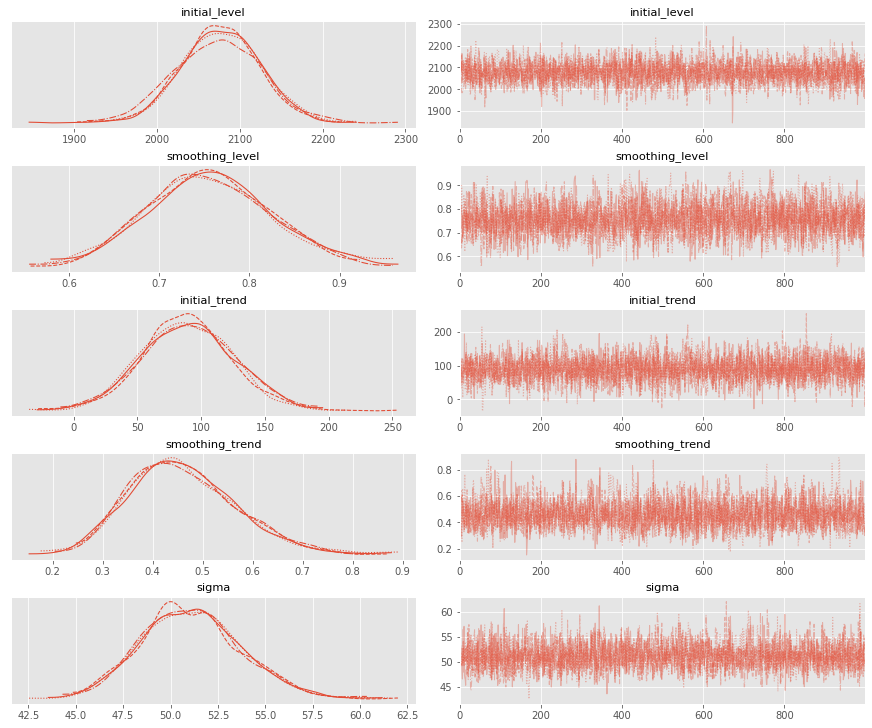

In [374]:
pm.traceplot(ses_trace)

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

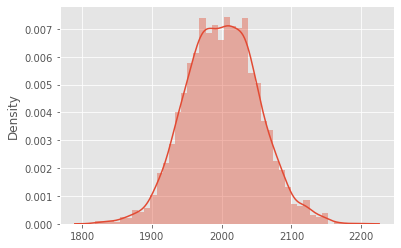

In [299]:
sns.distplot(ses_trace['initial_level'])

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

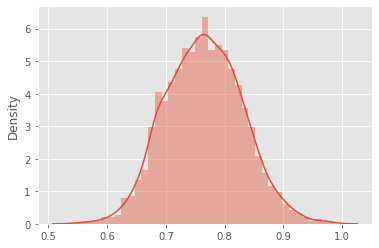

In [300]:
sns.distplot(ses_trace['smoothing_level'])

In [375]:
mean_initial_level = ses_trace['initial_level'].mean()
mean_initial_level

2076.0419414740263

In [376]:
mean_smoothing_level = ses_trace['smoothing_level'].mean()
mean_smoothing_level

0.7556359260504703

In [377]:
mean_initial_trend = ses_trace['initial_trend'].mean()
mean_initial_trend

89.47198066909597

In [378]:
mean_smoothing_trend = ses_trace['smoothing_trend'].mean()
mean_smoothing_trend

0.4614542295933782

In [379]:
mean_sigma = ses_trace['sigma'].mean()
mean_sigma

51.112611353211044

In [381]:
d2.loc[0, 'level_hat'] = mean_initial_level
d2.loc[0, 'trend_hat'] = mean_initial_trend

In [386]:
d2.head(6)

,y,level,trend,y_lag-1,level_hat,trend_hat,y_hat
0,NaN,2000.000000,100.000000,2166.875657,2076.041941,89.471981,NaN
1,2166.875657,2153.500526,120.062697,2242.358769,2166.542898,89.946806,2256.489704
2,2242.358769,2248.599660,110.701361,2376.927038,2245.811862,85.019471,2330.831333
3,2376.927038,2373.401835,115.989166,2387.300126,2365.662904,101.092647,2466.755551
4,2387.300126,2407.718301,85.361904,2539.345462,2406.716177,73.387224,2480.103401
5,2539.345462,2530.092410,99.241481,2632.641188,2524.868830,94.044421,2618.913251


In [384]:
for idx, row in d2.iloc[1:,:].iterrows():
#     print('idx', idx)
    
    level_m1 = d2.loc[idx-1]['level_hat']
    trend_m1 = d2.loc[idx-1]['trend_hat']
    y = row['y']
#     print('level_minus_1', level_minus_1)
#     print('y', y)
    
    level_m0 = mean_smoothing_level*y + (1 - mean_smoothing_level)*(level_m1 + trend_m1)
    d2.loc[idx, 'level_hat'] = level_m0
    
    trend_m0 = mean_smoothing_trend*(level_m0 - level_m1) + (1 - mean_smoothing_trend)*trend_m1
    d2.loc[idx, 'trend_hat'] = trend_m0
    
    d2.loc[idx, 'y_hat'] = level_m0 + trend_m0

<AxesSubplot:>

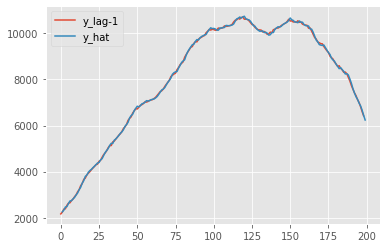

In [385]:
d2[['y_lag-1', 'y_hat']].plot()

### End With Trend Component

### Start With Seasonal Component

<AxesSubplot:>

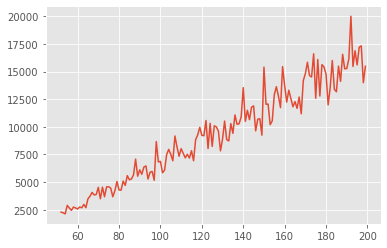

In [635]:
### Specifying DES as State Space Model
### ETS(A,A,N)

initial_level, smoothing_level = 2000, 0.8
initial_trend, smoothing_trend = 100, 0.3
smoothing_szn = 0.5
szn_len = 52

ys = [None for i in range(200)]
ls = [None for i in range(200)]
bs = [None for i in range(200)]
ss = [None for i in range(200)]
ls[51] = initial_level
bs[51] = initial_trend
noises = []

for i in range(szn_len):
    ss[i] = np.random.normal(1,0.10)

for i in range(52, 200):
    
#     noise = np.random.normal(0, 50)
    noise = 0
    noises.append(noise)
#     if i >= szn_len:
#         szn_idx = i - szn_len
#         ss[i] = ss[szn_idx] + smoothing_szn * noise / (ls[i-1] + bs[i-1])
#     else:
#         szn_idx = i
        
    ss[i] = ss[i-52] + smoothing_szn * noise / (ls[i-1] + bs[i-1])
    ys[i] = (ls[i-1] + bs[i-1])*ss[i-52] + noise
    ls[i] = ls[i-1] + bs[i-1] + smoothing_level * noise / ss[i-52]
    bs[i] = bs[i-1] + smoothing_trend * noise
    
        

d3 = pd.DataFrame({'y': ys, 'level': ls, 'trend': bs, 'season': ss})

d3['y_lag-1'] = d3.y.shift(-1)

d3.y.plot()

<AxesSubplot:>

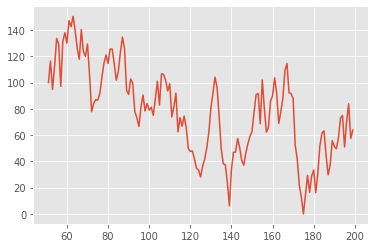

In [611]:
d3.trend.plot()

<AxesSubplot:>

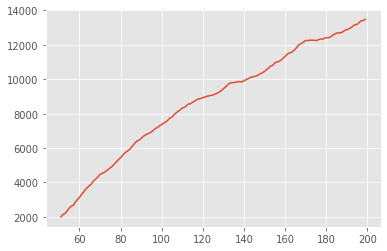

In [612]:
d3.level.plot()

<AxesSubplot:>

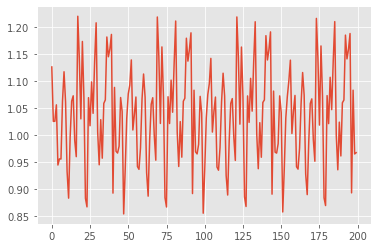

In [613]:
d3.season.plot()

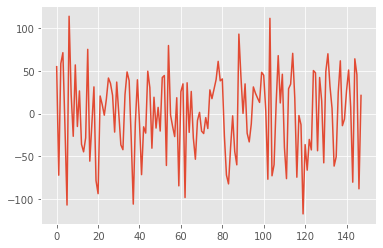

In [614]:
plt.plot(noises)

In [615]:
pd.Series(noises).describe()

count    148.000000
mean      -0.814587
std       48.018573
min     -117.473332
25%      -33.857057
50%        2.071815
75%       35.458706
max      113.957339
dtype: float64

In [640]:
ls[52:60]

[2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 2700.0, 2800.0]

In [641]:
outputs[0].get_test_value()[:8]

array([2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800.])

In [642]:
bs[52:60]

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]

In [643]:
outputs[1].get_test_value()[:8]

array([100., 100., 100., 100., 100., 100., 100., 100.])

In [644]:
ss[52:55]

[1.0903573086187692, 1.013726918268612, 0.9241210528236156]

In [645]:
outputs[2].get_test_value()[:3]

array([1.09035731, 1.01372692, 0.92412105])

In [630]:
len(outputs[2].get_test_value())

148

In [646]:
ss[-5:]

[0.950948051650385,
 1.0421242589458064,
 1.043451992655666,
 0.8378764154106525,
 0.9211250690916735]

In [647]:
outputs[2].get_test_value()[-5:]

array([0.95094805, 1.04212426, 1.04345199, 0.83787642, 0.92112507])

In [ ]:
# maybe look at how statsmodels handles the initial seasons stuff

In [636]:
def my_func2(y, prior_level, prior_trend, szn_m52):
#     import pdb; pdb.set_trace()
    updated_szn = smoothing_szn * y / (prior_level + prior_trend) + (1 - smoothing_szn) * szn_m52
#     next_szn_final = (1 - special_idx) * szn_m52 + special_idx * updated_szn
    
        
    next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + prior_trend)
    next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend
    
    return next_level, next_trend, updated_szn

outputs, updates = theano.scan(my_func2,
           sequences = [
               tt.as_tensor_variable(ys[52:]),
#                tt.as_index_constant(indices)
#                tt.as_tensor_variable(indices)
#                tt.as_index_constant(indices)
#                tt.arange(len(ys[1:]))
#                tt.as_index_constant([t for t in range(len(ys[1:]))])
#                np.array(ys[1:]),
#                np.array(ys[1:])
#                np.array([t for t in range(len(ys[1:]))])
           ], # first arg should be ys[t]
           outputs_info = [
               dict(initial = pm.math.floatX(ls[51]), taps=None),
               dict(initial = pm.math.floatX(bs[51]), taps=None),
               dict(initial = tt.as_tensor_variable(ss[:szn_len]), taps=[-szn_len])
#                dict(initial = tt.as_tensor_variable(ss[1:szn_len]), taps=[-szn_len])
#                dict(initial = tt.as_tensor_variable(ss[:szn_len]), taps=[-szn_len])
#                dict(initial = pm.math.floatX(ss[0]), taps=[-szn_len])
           ], # taps = None is equivalent to taps=[-1]
#            non_sequences = 
           )

WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


In [372]:
with pm.Model() as ses_model:
#     initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000, shape=(1,1))
    initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000)
    smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
    initial_trend = pm.Uniform(f'initial_trend', lower=-5000, upper=5000)
    smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
    
    # move this out? or use scan? does this create unnecessary var's?
#     levels = [1.0 for i in range(len(d))]
#     levels[0] = initial_level
    
    # move this out? or use scan? does this create unnecessary var's?
#     for i in range(1, len(d)):
# #         levels[i] = pm.Deterministic(f'level_{i}',smoothing_level*(d.loc[i]['y']) \
# #                                      + (1 - smoothing_level)*(levels[i-1]))
#         levels[i] = smoothing_level*(d.loc[i]['y']) + (1 - smoothing_level)*(levels[i-1])

    ys = d2['y']
    
#     levels, updates = theano.scan(fn = lambda y, prior_level: smoothing_level * y + (1 - smoothing_level) * prior_level,
#            sequences = [
#                np.array(ys[1:])
#            ], # first arg should be ys[t]
#            outputs_info = [
# #                dict(initial = pm.math.floatX(ls[0]), taps=None)
#                dict(initial = initial_level, taps=None)
#            ], # taps = None is equivalent to taps=[-1]
# #            non_sequences = 
#            )
    
    def level_and_trend_fn(y, prior_level, prior_trend):
        next_level = smoothing_level * y + (1 - smoothing_level)*(prior_level + prior_trend)
        next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend

        return next_level, next_trend
    
    outputs, updates = theano.scan(level_and_trend_fn,
           sequences = [
               np.array(ys[1:])
           ], # first arg should be ys[t]
           outputs_info = [
               dict(initial = initial_level, taps=None),
               dict(initial = initial_trend, taps=None)
           ], # taps = None is equivalent to taps=[-1]
#            non_sequences = 
           )
    
    levels = outputs[0]
    trends = outputs[1]

    levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
    trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
    
    levels_and_trends = pm.math.stack([levels_f, trends_f])
    y_hats = levels_and_trends.sum(axis=0)
    
#     levels_and_slopes = pm.math.stack([levels[:-1], slopes[:-1]])
#     levels_plus_slopes = levels_and_slopes.sum(axis=0)
#     levels_slopes_seasons = pm.math.stack([levels_plus_slopes, seasons[:-1]])
#     y_hats = levels_slopes_seasons.prod(axis=0)
    
    sigma = pm.Uniform('sigma', lower=0, upper=400)
    y_like = pm.Normal('y_like', mu=y_hats, sigma=sigma, observed=d2.iloc[:-1, :]['y_lag-1'])

WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


In [373]:
with ses_model:
#     ses_trace = pm.sample(draws=2000, tune=2000, target_accept=0.95)
#     ses_trace = pm.sample(draws=16000)
    ses_trace = pm.sample()

<ipython-input-373-61fa207d68dc>:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  ses_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, smoothing_trend, initial_trend, smoothing_level, initial_level]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


<ipython-input-374-72d66f4cf359>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(ses_trace)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'initial_level'}>,
        <AxesSubplot:title={'center':'initial_level'}>],
       [<AxesSubplot:title={'center':'smoothing_level'}>,
        <AxesSubplot:title={'center':'smoothing_level'}>],
       [<AxesSubplot:title={'center':'initial_trend'}>,
        <AxesSubplot:title={'center':'initial_trend'}>],
       [<AxesSubplot:title={'center':'smoothing_trend'}>,
        <AxesSubplot:title={'center':'smoothing_trend'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

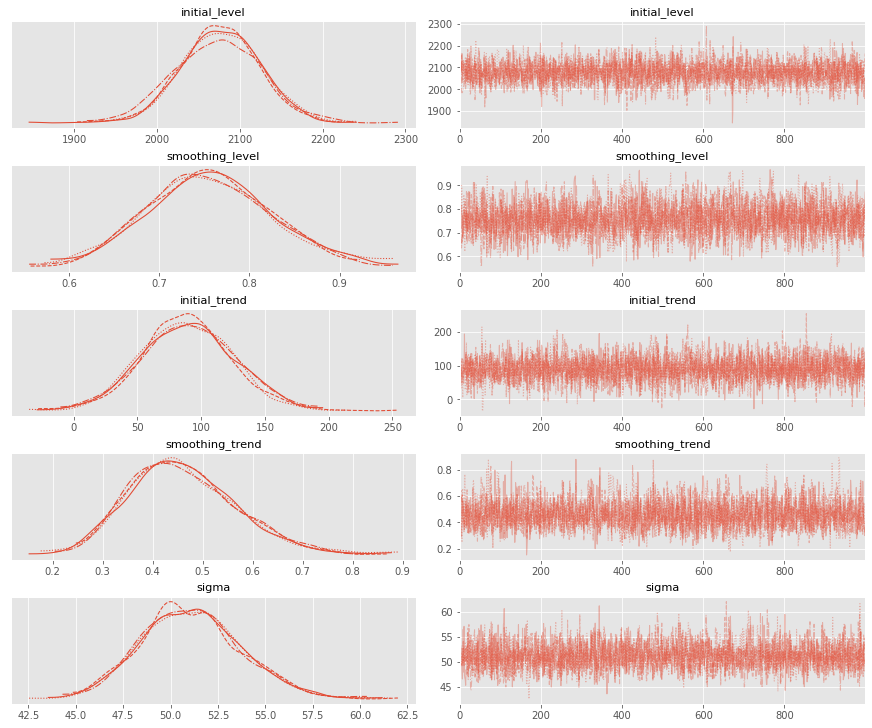

In [374]:
pm.traceplot(ses_trace)

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

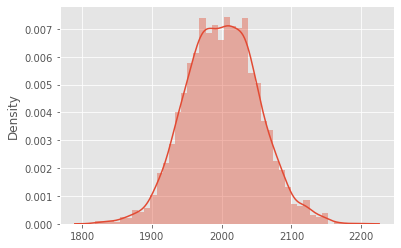

In [299]:
sns.distplot(ses_trace['initial_level'])

/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

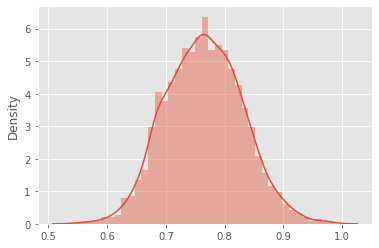

In [300]:
sns.distplot(ses_trace['smoothing_level'])

In [375]:
mean_initial_level = ses_trace['initial_level'].mean()
mean_initial_level

2076.0419414740263

In [376]:
mean_smoothing_level = ses_trace['smoothing_level'].mean()
mean_smoothing_level

0.7556359260504703

In [377]:
mean_initial_trend = ses_trace['initial_trend'].mean()
mean_initial_trend

89.47198066909597

In [378]:
mean_smoothing_trend = ses_trace['smoothing_trend'].mean()
mean_smoothing_trend

0.4614542295933782

In [379]:
mean_sigma = ses_trace['sigma'].mean()
mean_sigma

51.112611353211044

In [381]:
d2.loc[0, 'level_hat'] = mean_initial_level
d2.loc[0, 'trend_hat'] = mean_initial_trend

In [386]:
d2.head(6)

,y,level,trend,y_lag-1,level_hat,trend_hat,y_hat
0,NaN,2000.000000,100.000000,2166.875657,2076.041941,89.471981,NaN
1,2166.875657,2153.500526,120.062697,2242.358769,2166.542898,89.946806,2256.489704
2,2242.358769,2248.599660,110.701361,2376.927038,2245.811862,85.019471,2330.831333
3,2376.927038,2373.401835,115.989166,2387.300126,2365.662904,101.092647,2466.755551
4,2387.300126,2407.718301,85.361904,2539.345462,2406.716177,73.387224,2480.103401
5,2539.345462,2530.092410,99.241481,2632.641188,2524.868830,94.044421,2618.913251


In [384]:
for idx, row in d2.iloc[1:,:].iterrows():
#     print('idx', idx)
    
    level_m1 = d2.loc[idx-1]['level_hat']
    trend_m1 = d2.loc[idx-1]['trend_hat']
    y = row['y']
#     print('level_minus_1', level_minus_1)
#     print('y', y)
    
    level_m0 = mean_smoothing_level*y + (1 - mean_smoothing_level)*(level_m1 + trend_m1)
    d2.loc[idx, 'level_hat'] = level_m0
    
    trend_m0 = mean_smoothing_trend*(level_m0 - level_m1) + (1 - mean_smoothing_trend)*trend_m1
    d2.loc[idx, 'trend_hat'] = trend_m0
    
    d2.loc[idx, 'y_hat'] = level_m0 + trend_m0

<AxesSubplot:>

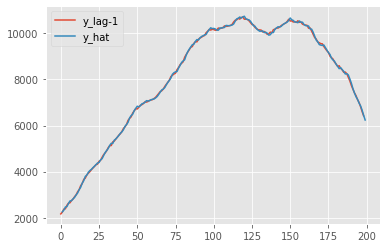

In [385]:
d2[['y_lag-1', 'y_hat']].plot()

### End With Seasonal Component

No handles with labels found to put in legend.


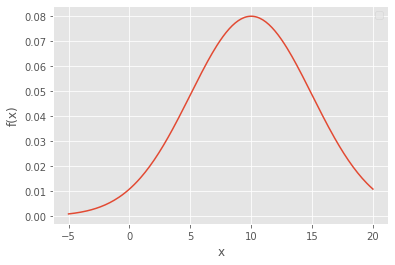

In [213]:
x = np.linspace(-5, 20, 200)
# for b in [0.25, 0.5, 1.0, 2.0]:
# for b in [0.1, 0.2]:
# for b in [2.0]:

pdf = st.norm.pdf(x, loc=10, scale=5)
plt.plot(x, pdf)
# plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

No handles with labels found to put in legend.


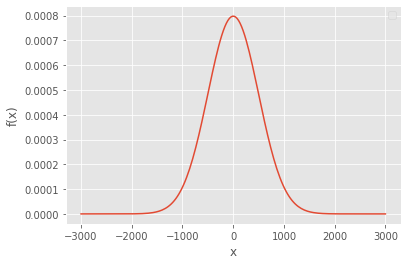

In [294]:
x = np.linspace(-3000, 3000, 200)
# for b in [0.25, 0.5, 1.0, 2.0]:
# for b in [0.1, 0.2]:
# for b in [2.0]:

pdf = st.norm.pdf(x, loc=0, scale=500)
plt.plot(x, pdf)
# plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

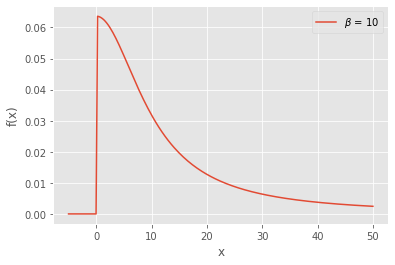

In [222]:
x = np.linspace(-5, 50, 200)
# for b in [0.25, 0.5, 1.0, 2.0]:
# for b in [0.1, 0.2]:
for b in [10]:
    pdf = st.halfcauchy.pdf(x, scale=b)
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [234]:
x = np.linspace(0, 20, 21)

In [235]:
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

No handles with labels found to put in legend.


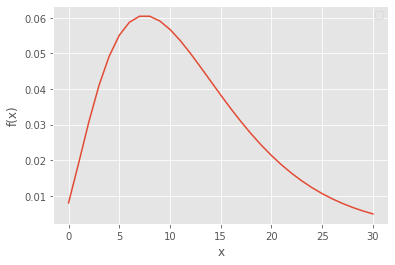

In [243]:
x = np.linspace(0, 30, 31)
n = 3
p = 0.2
pmf = st.nbinom.pmf(x, n, p)
plt.plot(x, pmf)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [ ]:
# [] try incorporating year 2020 unique multipliers
# [] also can allow for some small # of changepoints in the level that happen around covid
    # [] the hope is that including these will make us not learn to overfit to most recent level
# [] see how well the data fits with this
# [] add a dampening parameter
# [] then can make it hierarchical
# [] longer term, could do a zone-embedding or multiple different hierarchical groups kinda approach, since all zones likely aren't from same hierarchical dist 

In [253]:
dfd = pd.read_csv('./weekly_dmd.csv')
dfd.head(2)

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag-1,total_demand_new_lag-2,smoothed_total_demand,year,total_demand_new_lag3,...,day,t4w_total_demand_lag2,szn_factor,pred_for_year,estimated_szn_factor,naive_pred,naive_error,naive_abs_error,naive_pct_error,naive_abs_pct_error
0,1,2017-06-12,462.874517,NaN,NaN,1844.63706,2070.638284,NaN,2017,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,641,2017-06-12,0.000000,NaN,NaN,0.00000,0.000000,NaN,2017,NaN,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [268]:
df = dfd.loc[dfd.zone_id == 1].reset_index(drop=True).loc[2:,:].reset_index(drop=True)
df.shape

(206, 24)

In [420]:
with pm.Model() as test:
#     seasons = np.array([0 for i in range(len(df))])
    x1 = pm.TruncatedNormal('x1', mu=1.0, sigma=0.3, lower=0, upper=2)
    x2 = pm.Deterministic('x2', x1 + 3)
    xs = [x1, x2]
    
    l1 = pm.TruncatedNormal('l1', mu=1.0, sigma=0.3, lower=0, upper=2)
    l2 = pm.Deterministic('l2', l1 + 3)
    ls = [l1, l2]
    
    s1 = pm.TruncatedNormal('s1', mu=2.0, sigma=0.3, lower=0, upper=2)
    s2 = pm.TruncatedNormal('s2', mu=0.5, sigma=0.3, lower=0, upper=2)
    ss = [s1, s2]
    
    y = pm.math.stack([xs, ls])
    z = y.sum(axis=0)
    fin = pm.math.stack([z, ss])
    finfin = fin.prod(axis=0)
#     z = 
    
#     fin = np.array(xs) * np.array(ls)
#     fin = pm.math.dot(xs, [1,2])
    
    eps = pm.HalfCauchy('eps', beta=1)
    
    y_like = pm.Normal('y_like', mu=finfin, sigma=eps, observed=[1,2])
    

In [421]:
# params to be estimated:
    # initial conditions (L_0, B_0, S_0, ..., S_51, and the weights alpha, beta, gamma)

# when fitting, should we think of it as fitting params such that the components at time t predict y(t+h) well or s.t. they predict y(t) well? can look at what statsmodels does. looks like it's y(t)
    # _holt_win_add_mul_dam

with pm.Model() as hier_model:
    season_length = 52
    m = season_length

    initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000)
    initial_slope = pm.Uniform(f'initial_slope', lower=-1000, upper=1000)
    
    levels = [1.0 for i in range(len(df))]
    slopes = [1.0 for i in range(len(df))]
    seasons = [1.0 for i in range(len(df))]

    # initial seasons
    for i in range(season_length):
        seasons[i] = pm.TruncatedNormal(f's_{i}', mu=1.0, sigma=0.3, lower=0, upper=2)

    levels[0] = initial_level
    slopes[0] = initial_slope



    
#     levels = pm.Uniform(f'levels', lower=0, upper=20000, shape=len(df))
#     slopes = pm.Uniform(f'slopes', lower=-1000, upper=1000, shape=len(df))
#     seasons = pm.TruncatedNormal(f'seasons', mu=1.0, sigma=0.3, lower=0, upper=2, shape=len(df))
    
    
    
    
    # [] check this: level and slope smoothers are constrained b/w 0 and 1. seasons b/w 0 and 1-smoothing_level. dampening_slope constrained b/w .8 and .98 usually
    smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
    smoothing_slope = pm.Uniform('smoothing_slope', lower=0, upper=1)
    smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1 - smoothing_level)
#     dampening_slope = 
    
    # l_change_2020_t should only be allowed to be non-zero a few times
    # probably also want a b_change_2020_t
    
    
#     n_level_changepoints = pm.NegativeBinomial('n_level_changepoints', n=3, p=0.2)
#     # ideally this is "without replacement"
#     level_changepoints = pm.DiscreteUniform('changepoints', lower=0, upper=season_length - 1, shape=n_level_changepoints)
#     level_changes = [pm.TruncatedNormal(f'level_change_{i}', mu=1.0, sigma=1.0, lower=0, upper=2.5) if i in level_changepoints else pm.Deterministic(f'level_change_{i}', 1.0) for i in range(season_length)]
    

#     for t in range(len(df)):
        # if year == 2020:
            # y_t = (l_t + h*b_t)*s_t_plus_h_min_mk_min_m*s_2020_t_plus_h_min_mk_min_m
            # l_t = (...) * l_change_2020_t
        # else:
            # y_t_plus_h = (l_t + h*b_t)*s_t_plus_h_min_mk_min_m
            # l_t = ...
        
#         L_sub_t = smoothing_level*(Y_sub_t / S_sub_t_min_m) + (1-smoothing_level) * (L_sub_t_min_1 + B_sub_t_min_1)
        
    # initial level, slope are learned so we skip the first record
#     for i, row in df[1:].iterrows():
    for i in range(1, len(df)):
#         if row['year'] == 2020:
            
#         else:
            # something seems up with this part
            # why is it s[i - m] in otexts and not just s[i]?
            # maybe just see if we can fit this simple model w/o the add'l changepoint stuff
            # can also try the state space form ish

#         levels[i] = smoothing_level*(df.loc[i]['total_demand_new'] / seasons[i]) \
#             + (1 - smoothing_level)*(levels[i-1] + slopes[i-1])
        levels[i] = pm.Deterministic(f'level_{i}', smoothing_level*(df.loc[i]['total_demand_new'] / seasons[i]) \
            + (1 - smoothing_level)*(levels[i-1] + slopes[i-1]))

#             levels[i] = smoothing_level*(df[i-1]['total_demand_new'] / seasons[i - 1]) \
#                 + (1 - smoothing_level)*(levels[i-1] + slopes[i-1])

#             levels[i] = smoothing_level*(row['total_demand_new'] / seasons[i - m]) \
#                 + (1 - smoothing_level)*(levels[i-1] + slopes[i-1])

#         slopes[i] = smoothing_slope*(levels[i] - levels[i-1]) \
#             + (1 - smoothing_slope)*slopes[i-1]
        slopes[i] = pm.Deterministic(f'slope_{i}', smoothing_slope*(levels[i] - levels[i-1]) \
            + (1 - smoothing_slope)*slopes[i-1])

#             seasons[i + m - 1] = smoothing_season * df[i+m-1]['total_demand_new'] / (levels[i+m-2] + slopes[i+m-2]) \
#                 + (1 - smoothing_season) * seasons[i - 1]

        if i >= season_length:
#             seasons[i] = smoothing_season * df.loc[i]['total_demand_new'] / (levels[i-1] + slopes[i-1]) \
#                 + (1 - smoothing_season) * seasons[i - m]
            seasons[i] = pm.Deterministic(f'season_{i}', smoothing_season * df.loc[i]['total_demand_new'] / (levels[i-1] + slopes[i-1]) \
                + (1 - smoothing_season) * seasons[i - m])
        
    levels_and_slopes = pm.math.stack([levels[:-1], slopes[:-1]])
    levels_plus_slopes = levels_and_slopes.sum(axis=0)
    levels_slopes_seasons = pm.math.stack([levels_plus_slopes, seasons[:-1]])
    y_hats = levels_slopes_seasons.prod(axis=0)
    
#     ys = (np.array(levels[:-1]) + np.array(slopes[:-1])) * np.array(seasons[:-1])
    
#     ys = pm.Deterministic('ys', (np.array(levels[:-1]) + np.array(slopes[:-1])) * np.array(seasons[:-1]))
    
#     ys = [0 for i in range(len(df) - 1)]
#     for i in range(0,len(df) - 1):
#         ys[i] = (levels[i] + slopes[i]) * seasons[i]

        
#     y_like = pm.Normal('y_like', mu=mu[zone_idx], sigma=sigma[zone_idx], observed=dd.zone_level_holiday_factor)
#     sigma = pm.HalfCauchy('sigma', beta=100)
    sigma = pm.Uniform('sigma', lower=0, upper=400)
#     y_like = pm.Normal('y_like', mu=[1.5 for i in range(205)], sigma=sigma, observed=df.loc[0:len(df)-2, 'total_demand_new_lag-1'])
    y_like = pm.Normal('y_like', mu=y_hats, sigma=sigma, observed=df.loc[0:len(df)-2, 'total_demand_new_lag-1'])
    
    # should prolly be an AR error structure here? so if time t is big +ve error, its pretty likely to see that at time t+1 too 

In [425]:
df_orig = df.copy()

In [426]:
df = df.loc[:55, :]

In [427]:
# params to be estimated:
    # initial conditions (L_0, B_0, S_0, ..., S_51, and the weights alpha, beta, gamma)

# when fitting, should we think of it as fitting params such that the components at time t predict y(t+h) well or s.t. they predict y(t) well? can look at what statsmodels does. looks like it's y(t)
    # _holt_win_add_mul_dam

with pm.Model() as hier_model:
    season_length = 52
    m = season_length

    initial_level = pm.Uniform(f'initial_level', lower=0, upper=20000)
    initial_slope = pm.Uniform(f'initial_slope', lower=-1000, upper=1000)
    
    levels = [1.0 for i in range(len(df))]
    slopes = [1.0 for i in range(len(df))]
    seasons = [1.0 for i in range(len(df))]

    # initial seasons
    for i in range(season_length):
        seasons[i] = pm.TruncatedNormal(f's_{i}', mu=1.0, sigma=0.3, lower=0, upper=2)

    levels[0] = initial_level
    slopes[0] = initial_slope



    
#     levels = pm.Uniform(f'levels', lower=0, upper=20000, shape=len(df))
#     slopes = pm.Uniform(f'slopes', lower=-1000, upper=1000, shape=len(df))
#     seasons = pm.TruncatedNormal(f'seasons', mu=1.0, sigma=0.3, lower=0, upper=2, shape=len(df))
    
    
    
    
    # [] check this: level and slope smoothers are constrained b/w 0 and 1. seasons b/w 0 and 1-smoothing_level. dampening_slope constrained b/w .8 and .98 usually
    smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
    smoothing_slope = pm.Uniform('smoothing_slope', lower=0, upper=1)
    smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1 - smoothing_level)
#     dampening_slope = 
    
    # l_change_2020_t should only be allowed to be non-zero a few times
    # probably also want a b_change_2020_t
    
    
#     n_level_changepoints = pm.NegativeBinomial('n_level_changepoints', n=3, p=0.2)
#     # ideally this is "without replacement"
#     level_changepoints = pm.DiscreteUniform('changepoints', lower=0, upper=season_length - 1, shape=n_level_changepoints)
#     level_changes = [pm.TruncatedNormal(f'level_change_{i}', mu=1.0, sigma=1.0, lower=0, upper=2.5) if i in level_changepoints else pm.Deterministic(f'level_change_{i}', 1.0) for i in range(season_length)]
    

#     for t in range(len(df)):
        # if year == 2020:
            # y_t = (l_t + h*b_t)*s_t_plus_h_min_mk_min_m*s_2020_t_plus_h_min_mk_min_m
            # l_t = (...) * l_change_2020_t
        # else:
            # y_t_plus_h = (l_t + h*b_t)*s_t_plus_h_min_mk_min_m
            # l_t = ...
        
#         L_sub_t = smoothing_level*(Y_sub_t / S_sub_t_min_m) + (1-smoothing_level) * (L_sub_t_min_1 + B_sub_t_min_1)
        
    # initial level, slope are learned so we skip the first record
#     for i, row in df[1:].iterrows():

    # can try to get rid of the loops here (1 below and above)
    # can we do matrix mul/linear alg instead?
        # ie maybe it doesn't matter that we iteratively build up? since it is compiled all at once
    # define outside?
    # use theano.scan?
    # could look at pyro
    # could look at just using torch or scipy and just coding up the model by hand like statsmodels is doing
    
#     levels = pm.Deterministic('levels', smoothing_level * , shape=len(df) - 1)

    for i in range(1, len(df)):
#         if row['year'] == 2020:
            
#         else:
            # something seems up with this part
            # X why is it s[i - m] in otexts and not just s[i]?
                # ah, it's actually just some algebra/substitution they did (explained in 'additive method' section here https://otexts.com/fpp2/holt-winters.html)
            # maybe just see if we can fit this simple model w/o the add'l changepoint stuff
            # can also try the state space form ish

#         levels[i] = smoothing_level*(df.loc[i]['total_demand_new'] / seasons[i]) \
#             + (1 - smoothing_level)*(levels[i-1] + slopes[i-1])
        levels[i] = pm.Deterministic(f'level_{i}', smoothing_level*(df.loc[i]['total_demand_new'] / seasons[i]) \
            + (1 - smoothing_level)*(levels[i-1] + slopes[i-1]))

#             levels[i] = smoothing_level*(df[i-1]['total_demand_new'] / seasons[i - 1]) \
#                 + (1 - smoothing_level)*(levels[i-1] + slopes[i-1])

#             levels[i] = smoothing_level*(row['total_demand_new'] / seasons[i - m]) \
#                 + (1 - smoothing_level)*(levels[i-1] + slopes[i-1])

#         slopes[i] = smoothing_slope*(levels[i] - levels[i-1]) \
#             + (1 - smoothing_slope)*slopes[i-1]
        slopes[i] = pm.Deterministic(f'slope_{i}', smoothing_slope*(levels[i] - levels[i-1]) \
            + (1 - smoothing_slope)*slopes[i-1])

#             seasons[i + m - 1] = smoothing_season * df[i+m-1]['total_demand_new'] / (levels[i+m-2] + slopes[i+m-2]) \
#                 + (1 - smoothing_season) * seasons[i - 1]

        if i >= season_length:
#             seasons[i] = smoothing_season * df.loc[i]['total_demand_new'] / (levels[i-1] + slopes[i-1]) \
#                 + (1 - smoothing_season) * seasons[i - m]
            seasons[i] = pm.Deterministic(f'season_{i}', smoothing_season * df.loc[i]['total_demand_new'] / (levels[i-1] + slopes[i-1]) \
                + (1 - smoothing_season) * seasons[i - m])
        
    levels_and_slopes = pm.math.stack([levels[:-1], slopes[:-1]])
    levels_plus_slopes = levels_and_slopes.sum(axis=0)
    levels_slopes_seasons = pm.math.stack([levels_plus_slopes, seasons[:-1]])
    y_hats = levels_slopes_seasons.prod(axis=0)
    
#     ys = (np.array(levels[:-1]) + np.array(slopes[:-1])) * np.array(seasons[:-1])
    
#     ys = pm.Deterministic('ys', (np.array(levels[:-1]) + np.array(slopes[:-1])) * np.array(seasons[:-1]))
    
#     ys = [0 for i in range(len(df) - 1)]
#     for i in range(0,len(df) - 1):
#         ys[i] = (levels[i] + slopes[i]) * seasons[i]

        
#     y_like = pm.Normal('y_like', mu=mu[zone_idx], sigma=sigma[zone_idx], observed=dd.zone_level_holiday_factor)
#     sigma = pm.HalfCauchy('sigma', beta=100)
    sigma = pm.Uniform('sigma', lower=0, upper=400)
#     y_like = pm.Normal('y_like', mu=[1.5 for i in range(205)], sigma=sigma, observed=df.loc[0:len(df)-2, 'total_demand_new_lag-1'])
    y_like = pm.Normal('y_like', mu=y_hats, sigma=sigma, observed=df.iloc[:-1, :]['total_demand_new_lag-1'])
    
    # should prolly be an AR error structure here? so if time t is big +ve error, its pretty likely to see that at time t+1 too 

In [428]:
with hier_model:
#     hier_trace = pm.sample(draws=2000, tune=2000, target_accept=0.95)
    hier_trace = pm.sample()

<ipython-input-428-cb4a6d4eb880>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  hier_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, smoothing_season, smoothing_slope, smoothing_level, s_51, s_50, s_49, s_48, s_47, s_46, s_45, s_44, s_43, s_42, s_41, s_40, s_39, s_38, s_37, s_36, s_35, s_34, s_33, s_32, s_31, s_30, s_29, s_28, s_27, s_26, s_25, s_24, s_23, s_22, s_21, s_20, s_19, s_18, s_17, s_16, s_15, s_14, s_13, s_12, s_11, s_10, s_9, s_8, s_7, s_6, s_5, s_4, s_3, s_2, s_1, s_0, initial_slope, initial_level]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 107 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<ipython-input-429-7ab9cfa04b90>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(hier_trace)
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.9.0/lib/python3.9/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (172), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'initial_level'}>,
        <AxesSubplot:title={'center':'initial_level'}>],
       [<AxesSubplot:title={'center':'initial_slope'}>,
        <AxesSubplot:title={'center':'initial_slope'}>],
       [<AxesSubplot:title={'center':'s_0'}>,
        <AxesSubplot:title={'center':'s_0'}>],
       [<AxesSubplot:title={'center':'s_1'}>,
        <AxesSubplot:title={'center':'s_1'}>],
       [<AxesSubplot:title={'center':'s_2'}>,
        <AxesSubplot:title={'center':'s_2'}>],
       [<AxesSubplot:title={'center':'s_3'}>,
        <AxesSubplot:title={'center':'s_3'}>],
       [<AxesSubplot:title={'center':'s_4'}>,
        <AxesSubplot:title={'center':'s_4'}>],
       [<AxesSubplot:title={'center':'s_5'}>,
        <AxesSubplot:title={'center':'s_5'}>],
       [<AxesSubplot:title={'center':'s_6'}>,
        <AxesSubplot:title={'center':'s_6'}>],
       [<AxesSubplot:title={'center':'s_7'}>,
        <AxesSubplot:title={'center':'s_7'}>],
       [<AxesSubplot:title={'c

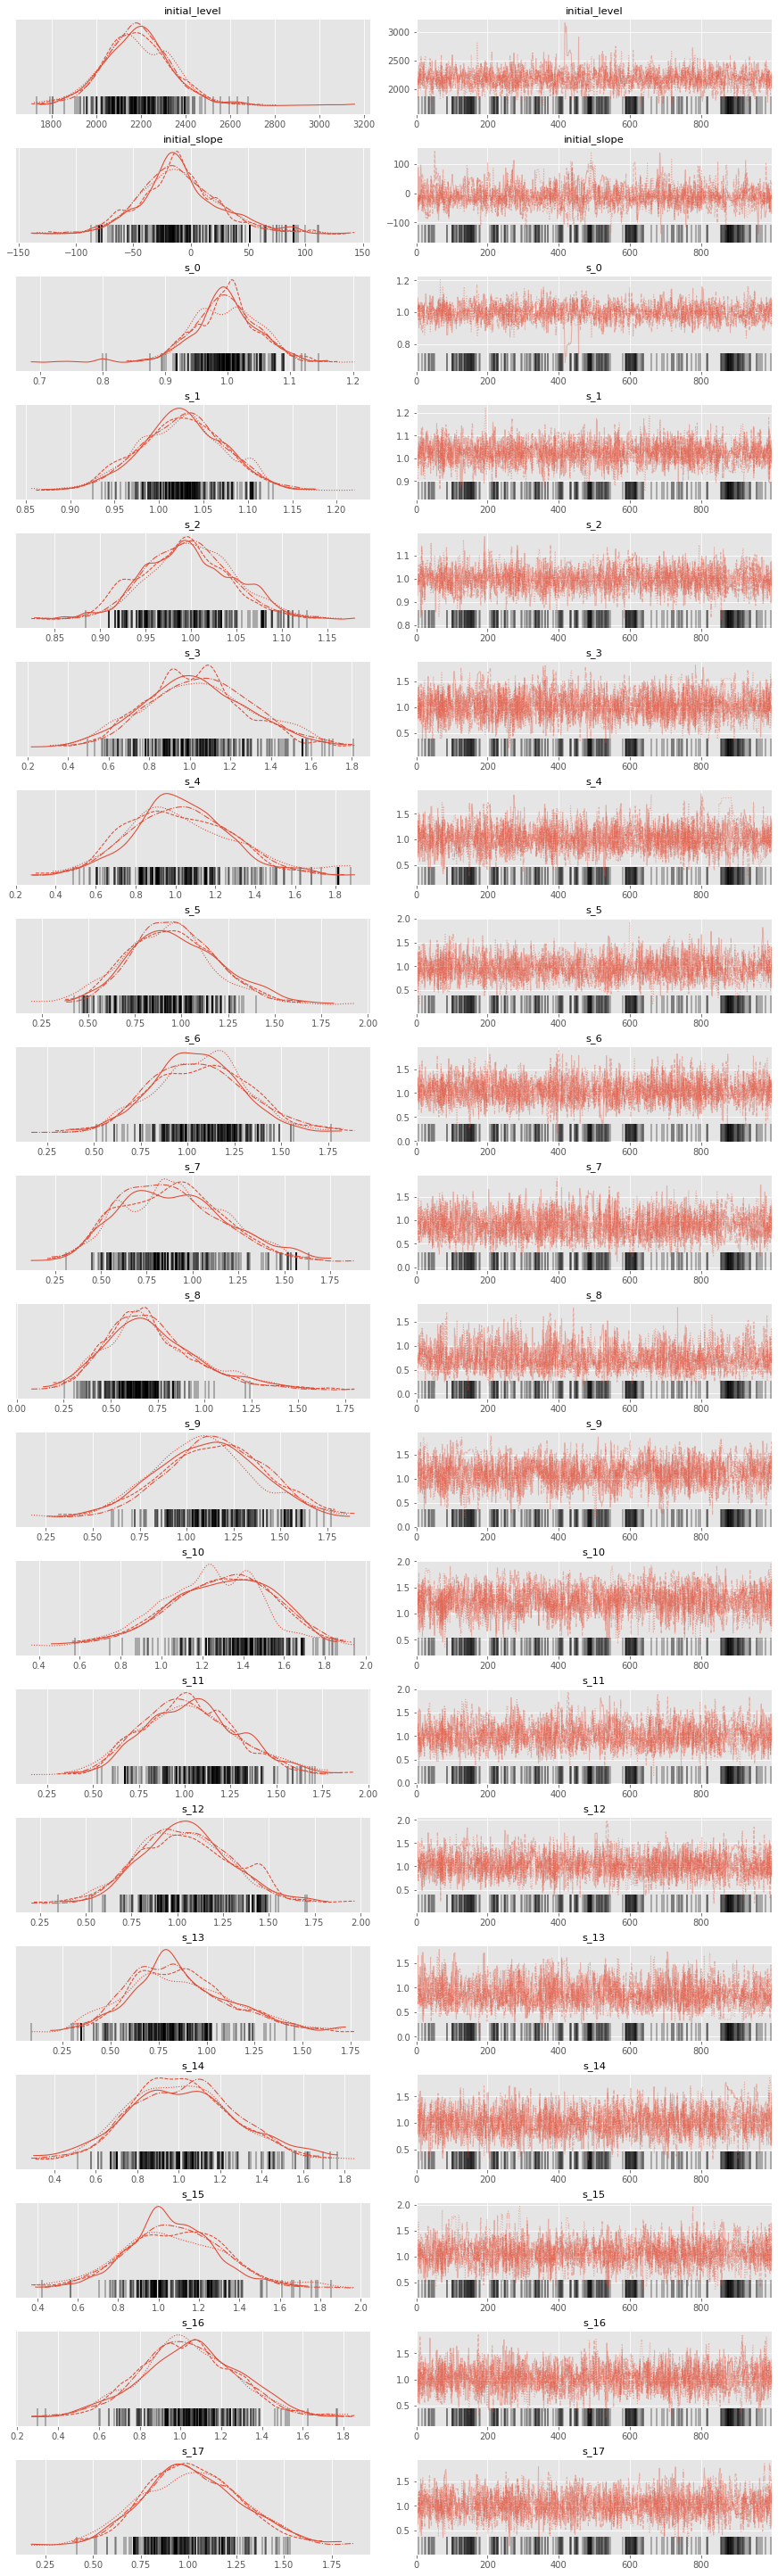

In [429]:
pm.traceplot(hier_trace)

In [353]:
with pm.Model() as hierarchical_model:
    # can make mu the nat'l avg for the zone
    mu_mu = pm.Normal('mu_mu', mu=dd.natl_holiday_factor.mean(), sigma=1)
    sigma_mu = pm.HalfCauchy('sigma_mu', beta=0.5)
    
#     mu_sigma = pm.HalfCauchy('mu_sigma', beta=0.1)
#     sigma_sigma = pm.HalfCauchy('sigma_sigma', beta=0.05)
    
    # mean for each zone, normally distributed around group mean mu_mu
    mu = pm.Normal('mu', mu=mu_mu, sigma=sigma_mu, shape=len(dd.zone_id.unique()))
    # variation/sigma for each zone, HalfCauchy-distributed (avg within-zone variation) 
    sigma = pm.HalfCauchy('sigma', beta=0.1, shape=len(dd.zone_id.unique()))
    
    # error
    
    # expected value
    
    # data likelihood
    # draw from zone dist
    
    y_like = pm.Normal('y_like', mu=mu[zone_idx], sigma=sigma[zone_idx], observed=dd.zone_level_holiday_factor)
    

In [354]:
mu

mu ~ Normal